This notebook introduces some features of [xarray](http://xarray.pydata.org/en/stable/index.html) and working with the CHAOS model residuals.

We show calculation of the residuals `data - CHAOS-6(Core+Static)`  and  `data - CHAOS-6(Core+Static+Magnetosphere)` and plot them separately for dayside and nightside data.

The CHAOS model is available on the server as model variables:
 - `CHAOS-6-Core`: SH degree 1-20
 - `CHAOS-6-Static`: SH degree 21-110
 - `CHAOS-6-MMA-Primary`: Magnetosphere external field, SH degree 1-2
 - `CHAOS-6-MMA-Secondary`: Magnetosphere internal induced field, SH degree 1-2
 
We use the abreviations:
 - `MCO`: core model
 - `MLI`: lithosphere model (i.e. static)
 - `MMA`: magnetosphere model

In [1]:
from viresclient import SwarmRequest
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

## Fetch the data-model residuals

Specify two custom models named as "CHAOS_MCO_MLI" and "CHAOS_MCO_MLI_MMA". Choose to fetch the B_NEC values. By specifying `residuals=True`, the data-model residuals for the B_NEC components will be evaluated directly.

In [2]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=[
        'B_NEC',
    ],
    models = [
        '"CHAOS_MCO_MLI" = "CHAOS-6-Core" + "CHAOS-6-Static"',
        '"CHAOS_MCO_MLI_MMA" = "CHAOS-6-Core" + "CHAOS-6-Static" + "CHAOS-6-MMA-Primary" + "CHAOS-6-MMA-Secondary"'
    ],
    residuals=True,
    auxiliaries=['QDLat', 'MLT', 'SunZenithAngle'],
    sampling_step="PT10S",
)
ds = request.get_between(
    start_time=dt.datetime(2014,1,1),
    end_time=dt.datetime(2014,1,2)
).as_xarray()

ds

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:06, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.914MB)


<xarray.Dataset>
Dimensions:                      (Timestamp: 8640, dim: 3)
Coordinates:
  * Timestamp                    (Timestamp) datetime64[ns] 2014-01-01 ... 2014-01-01T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft                   (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                     (Timestamp) float64 -1.229 -1.863 ... -81.46
    Longitude                    (Timestamp) float64 -14.12 -14.13 ... 1.072
    Radius                       (Timestamp) float64 6.878e+06 ... 6.88e+06
    B_NEC_res_CHAOS_MCO_MLI      (Timestamp, dim) float64 -9.402 ... -6.121
    B_NEC_res_CHAOS_MCO_MLI_MMA  (Timestamp, dim) float64 1.002 -2.386 ... 15.81
    QDLat                        (Timestamp) float64 -11.99 -12.6 ... -69.49
    MLT                          (Timestamp) float64 22.69 22.68 ... 21.24 21.2
    SunZenithAngle               (Timestamp) float64 151.7 151.2 ... 76.22 75.61
Attributes:
    Sources:         ['CHAOS-6_static.shc', '

Each "Data variable" (like a dataframe column) can be extracted as a [`xarray.DataArray`](http://xarray.pydata.org/en/stable/data-structures.html#dataarray) object e.g. `ds["Latitude"]`).

All measurements follow a coordinate set of `Timestamp` (like an index). The vector measurements have an additional dimension which is just called `dim` which is of size 3 to account for the three components (N, E, C).

One dimension can be extracted like indexing into a numpy `ndarray`. The N (Northwards) component is accessed as:

In [3]:
ds["B_NEC_res_CHAOS_MCO_MLI"][:,0]

<xarray.DataArray 'B_NEC_res_CHAOS_MCO_MLI' (Timestamp: 8640)>
array([ -9.402488,  -9.18182 ,  -8.99633 , ..., -66.360776, -79.583125,
       -91.840107])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2014-01-01 ... 2014-01-01T23:59:50

`xarray.DataArray` have similar methods as `pandas.DataFrame` objects, such as plotting directly:

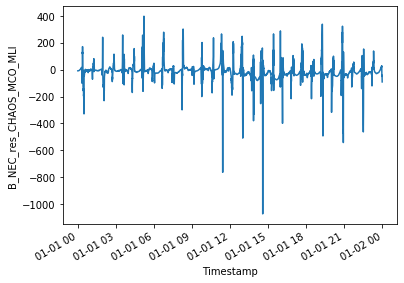

In [5]:
ds["B_NEC_res_CHAOS_MCO_MLI"][:,0].plot();

and the numpy `ndarray` can be extracted using `.values`:

In [6]:
ds["B_NEC_res_CHAOS_MCO_MLI"][:,0].values

array([ -9.40248834,  -9.18182017,  -8.99632976, ..., -66.36077639,
       -79.58312534, -91.84010736])

## Append new columns to the dataset containing the custom residuals

New variables can be added to the dataset just like with dictionaries, and arithmetic operations can be performed on variables directly.

In [7]:
ds["QDCoLat"] = 90 - ds["QDLat"]
ds

<xarray.Dataset>
Dimensions:                      (Timestamp: 8640, dim: 3)
Coordinates:
  * Timestamp                    (Timestamp) datetime64[ns] 2014-01-01 ... 2014-01-01T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft                   (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                     (Timestamp) float64 -1.229 -1.863 ... -81.46
    Longitude                    (Timestamp) float64 -14.12 -14.13 ... 1.072
    Radius                       (Timestamp) float64 6.878e+06 ... 6.88e+06
    B_NEC_res_CHAOS_MCO_MLI      (Timestamp, dim) float64 -9.402 ... -6.121
    B_NEC_res_CHAOS_MCO_MLI_MMA  (Timestamp, dim) float64 1.002 -2.386 ... 15.81
    QDLat                        (Timestamp) float64 -11.99 -12.6 ... -69.49
    MLT                          (Timestamp) float64 22.69 22.68 ... 21.24 21.2
    SunZenithAngle               (Timestamp) float64 151.7 151.2 ... 76.22 75.61
    QDCoLat                      (Timestamp) float64 102.

## Use [`xarray.Dataset.where()`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.where.html#xarray.Dataset.where) to filter the dataset

Here we subselect the dataset into dayside and nightside parts, according to the MLT. Alternatively, we could have used [`set_range_filter`](https://viresclient.readthedocs.io/en/latest/api.html#viresclient.SwarmRequest.set_range_filter) in the request to get the same filtered data. Since we will filter by MLT in two different ways, we would have to make more than one request.

`drop=True` tells it to remove the filtered-out entries, otherwise they are filled with NaN (see how the `Timestamp` dimension has dropped from 86400 to 43782).

In [8]:
ds.where((ds.MLT < 6) | (ds.MLT > 18), drop=True)

<xarray.Dataset>
Dimensions:                      (Timestamp: 4380, dim: 3)
Coordinates:
  * Timestamp                    (Timestamp) datetime64[ns] 2014-01-01 ... 2014-01-01T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft                   (Timestamp) object 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                     (Timestamp) float64 -1.229 -1.863 ... -81.46
    Longitude                    (Timestamp) float64 -14.12 -14.13 ... 1.072
    Radius                       (Timestamp) float64 6.878e+06 ... 6.88e+06
    B_NEC_res_CHAOS_MCO_MLI      (Timestamp, dim) float64 -9.402 ... -6.121
    B_NEC_res_CHAOS_MCO_MLI_MMA  (Timestamp, dim) float64 1.002 -2.386 ... 15.81
    QDLat                        (Timestamp) float64 -11.99 -12.6 ... -69.49
    MLT                          (Timestamp) float64 22.69 22.68 ... 21.24 21.2
    SunZenithAngle               (Timestamp) float64 151.7 151.2 ... 76.22 75.61
    QDCoLat                      (Timestamp) float64 102.0

`ds.where()` returns a new dataset, which we can operate on directly without creating a new variable. Here we use the default behaviour of `drop=False` so the dataset contains NaNs in the empty parts. We extract the `Latitude` [`DataArray`](http://xarray.pydata.org/en/stable/data-structures.html#dataarray) from the [`Dataset`](http://xarray.pydata.org/en/stable/data-structures.html#dataset) then use [`xarray.DataArray.plot()`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html) which (without any kwargs) will automatically try to plot the the quantity against its coordinate (`Timestamp`).

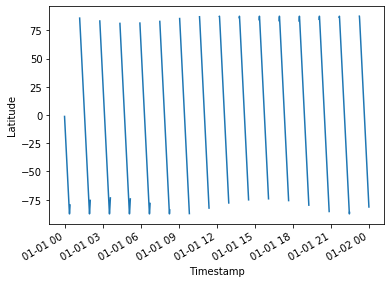

In [9]:
ds.where((ds.MLT < 6) | (ds.MLT > 18))["Latitude"].plot();

We can split the original dataset apart into two, one night and one day.  Sometimes it may be preferable to not create these new datasets but it will be clearer to do so here. (You might instead filter by `SunZenithAngle` but here `MLT` is used)

In [10]:
ds_night = ds.where((ds.MLT < 6) | (ds.MLT > 18))
ds_day = ds.where((ds.MLT >= 6) & (ds.MLT <= 18))

## Create a `matplotlib` figure with subplots and plot onto them



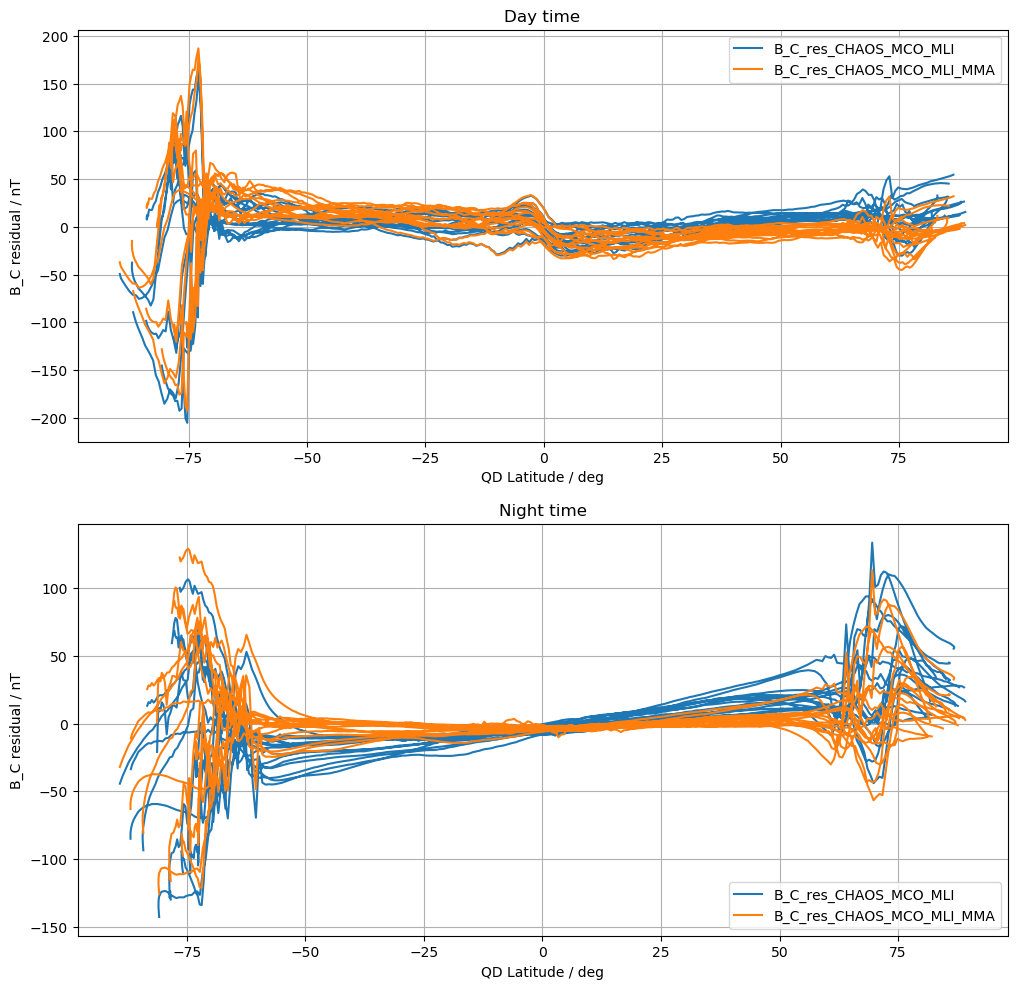

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), dpi=100)

for ax, ds_subset, title in zip(axes, (ds_day, ds_night), ("Day time", "Night time")):
    ax.plot(
        ds_subset["QDLat"].values,
        ds_subset["B_NEC_res_CHAOS_MCO_MLI"][:,2].values,
        label="B_C_res_CHAOS_MCO_MLI"
    )
    ax.plot(
        ds_subset["QDLat"].values,
        ds_subset["B_NEC_res_CHAOS_MCO_MLI_MMA"][:,2].values,
        label="B_C_res_CHAOS_MCO_MLI_MMA"
    )
    ax.set_title(title)
    ax.legend()
    ax.grid()
    ax.set_ylabel("B_C residual / nT")   
    ax.set_xlabel("QD Latitude / deg")